# Bayesian Hyperparameter Inference for Gaussian Process Regression with US Census Data

In this experiment, we perform Bayesian inference on the hyperparameters of a Gaussian process regression model for a subset of some recent US census data, which can be retrieved from [Kaggle](https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data?resource=download&select=acs2015_county_data.csv), normalized so that both the features and the target variable have sample mean zero and sample variance one. Our inspiration for this is an experiment on the same type problem but for different data that was described by [Nishihara et al. (2014)](https://www.jmlr.org/papers/volume15/nishihara14a/nishihara14a.pdf)

The target distribution is constructed as follows. Denote the given data as $(a,b) = (a^{(i)},b^{(i)})_{i=1,...,n_{\text{data}}}$, where $a^{(i)} \in \mathbb{R}^d$ and $b^{(i)} \in \mathbb{R}$. Suppose we want to model the data by *Gaussian process* (GP) *regression*. That is, we model it by a posterior distribution over an infinite-dimensional space of latent functions $f: \mathbb{R}^d \rightarrow \mathbb{R}$. The likelihood is obtained from

$$
b^{(i)} = f(a^{(i)}) + \varepsilon_i ,
\qquad \varepsilon_i \sim \mathcal{N}(0,\sigma^2) ,
$$

with the noise variables $\varepsilon_i$ being independent and $\sigma^2 \geq 0$ a fixed hyperparameter (we use $\sigma^2 = 10^{-2}$).
The prior is a GP prior with mean zero and covariance determined by an *anisotropic radial basis function* (RBF) *kernel*, i.e. a function $k^{(\gamma)}: \mathbb{R}^d \rightarrow \mathbb{R}^d$ of the form

$$
k^{(\gamma)}(a, a^{\prime}) 
= \exp\left( -\frac{1}{2} \sum_{j=1}^d \frac{(a_j - a^{\prime}_j)^2}{\gamma_j^2} \right) ,
\qquad a, a^{\prime} \in \mathbb{R}^d ,
$$

which has $d$ length scale parameters $\gamma = (\gamma_1,...,\gamma_d) \in \; ]0,\infty[^d$ that are a priori hyperparameters to the GP regression model.

To obtain a good model, we want to infer these length scale hyperparameters through the Bayesian framework, which is commonly done by placing a suitable prior on them and using the marginal likelihood of the data in the above GP model as the likelihood for a given $\gamma$ (see [Rasmussen & Williams (2006)](https://gaussianprocess.org/gpml/chapters/RW.pdf), Chapter 5). Recall that the *kernel matrix* for the data $(a,b)$ corresponding to the kernel $k^{(\gamma)}$ is the matrix $K^{(\gamma)} \in \mathbb{R}^{n_{\text{data}} \times n_{\text{data}}}$ with entries

$$
K^{(\gamma)}_{i,i^{\prime}} = k^{(\gamma)}(a^{(i)}, a^{(i^{\prime})}) ,
\qquad i,i^{\prime} \in \{1,...,n_{\text{data}}\} ,
$$

and note that it can be used to concisely write the marginal likelihood of the data for a given kernel $k^{(\gamma)}$ as

$$
p(b \mid a, \gamma)
= \mathcal{N}_{n_{\text{data}}}(b; 0, K^{(\gamma)} + \sigma^2 I_{n_{\text{data}}})
\propto \det(K^{(\gamma)} + \sigma^2 I_{n_{\text{data}}})^{-1/2} \exp\left( -\frac{1}{2} b^T (K^{(\gamma)} + \sigma^2 I_{n_{\text{data}}})^{-1} b \right) ,
\qquad \gamma \in \; ]0,\infty[^d ,
$$

see [Rasmussen & Williams (2006)](https://gaussianprocess.org/gpml/chapters/RW.pdf), equation 5.8. Following [Nishihara et al. (2014)](https://www.jmlr.org/papers/volume15/nishihara14a/nishihara14a.pdf), we use the independent exponential prior

$$
p(\gamma) 
= \prod_{j=1}^d \text{Exp}(\gamma_j; r)
\propto \exp\left( -r \sum_{j=1}^d \gamma_j \right)
$$

with fixed rate $r = 0.1$. 

As this target is only supported on $]0,\infty[^d$, we transform it into one supported on all of $\mathbb{R}^d$. Following the [defaults of Stan](https://mc-stan.org/docs/reference-manual/transforms.html#lower-bound-transform.section) for such cases, we do this by sampling the logarithms of the variables of interest instead of the variables themselves, i.e.~we use the transformation $\beta := \log(\gamma) := (\log(\gamma_1), \dots, \log(\gamma_d))$, which obviously has inverse transformation $\gamma = \exp(\beta) := (\exp(\beta_1), \dots, \exp(\beta_d))$. This results in the target density

$$
\varrho(\beta) 
= \exp\left(\sum_{j=1}^d \beta_j\right) \exp\left( -r \sum_{j=1}^d \exp(\beta_j) \right) \det(K^{(\exp(\beta))} + \sigma^2 I_{n_{\text{data}}})^{-1/2} \exp\left( -\frac{1}{2} b^T (K^{(\exp(\beta))} + \sigma^2 I_{n_{\text{data}}})^{-1} b \right) ,
\qquad \beta \in \mathbb{R}^d ,
$$

which corresponds to the log target density

$$
\log \varrho(\beta)
= \sum_{j=1}^d \beta_j -r \sum_{j=1}^d \exp(\beta_j) - \frac{1}{2} \log\!\big(\!\det(K^{(\exp(\beta))} + \sigma^2 I_{n_{\text{data}}})\big) -\frac{1}{2} b^T (K^{(\exp(\beta))} + \sigma^2 I_{n_{\text{data}}})^{-1} b ,
\qquad \beta \in \mathbb{R}^d .
$$

Note that, unfortunately, the Bayesian approach employed here to infer the parameters $\gamma = \exp(\beta)$ is computationally infeasible for all but the smallest data sets because every evaluation of the above target density involves computing the kernel matrix $K^{(\gamma)}$, which has complexity $\mathcal{O}(n_{\text{data}}^2 d)$, as well as the inverse and determinant of $K^{(\gamma)} + \sigma^2 I_{n_{\text{data}}}$, each of which has complexity $\mathcal{O}(n_{\text{data}}^3)$.

In [1]:
from patt_mcmc import patt_ess, patt_gpss
from hit_and_run_uniform_slice_sampling import parallel_hruss
from random_walk_metropolis import parallel_ada_rwm
import stan_utils as su
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
import pandas as pd
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import time as tm
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
path_prefix = "../plots/Bayesian_hyperparam_inf_GP_regression_"

### Construct Target Density
#### Retrieve and Preprocess the Data

In [4]:
# load data set from file
data = pd.read_csv("../data/acs2015_county_data.csv")
data

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,Puerto Rico,Vega Baja,56858,27379,29479,96.4,3.4,0.1,0.0,...,1.2,1.3,0.3,32.0,13660,78.3,17.6,4.1,0.0,15.2
3216,72147,Puerto Rico,Vieques,9130,4585,4545,96.7,2.9,0.0,0.0,...,10.8,0.0,1.4,14.0,2860,44.5,41.6,13.6,0.3,12.2
3217,72149,Puerto Rico,Villalba,24685,12086,12599,99.7,0.0,0.0,0.0,...,3.2,0.0,3.3,26.9,6795,59.2,27.5,13.1,0.2,25.9
3218,72151,Puerto Rico,Yabucoa,36279,17648,18631,99.8,0.2,0.0,0.0,...,2.3,2.3,1.5,29.5,8083,65.1,27.6,7.3,0.0,24.3


In [5]:
# create copy of the data with all unwanted columns and the target variable removed
removed_cols = [
    'CensusId', # unique id of each data point
    'State', # categorical
    'County', # another unique identifier of each data point
    'Income', # median household income; the target variable for regression
    'IncomeErr', # too closely linked to the target variable
    'IncomePerCap', # too closely linked to the target variable
    'IncomePerCapErr', # too closely linked to the target variable
]
filtered_data = data.drop(columns = removed_cols)
filtered_data

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,56858,27379,29479,96.4,3.4,0.1,0.0,0.0,0.0,43656,...,1.2,1.3,0.3,32.0,13660,78.3,17.6,4.1,0.0,15.2
3216,9130,4585,4545,96.7,2.9,0.0,0.0,0.0,0.0,7085,...,10.8,0.0,1.4,14.0,2860,44.5,41.6,13.6,0.3,12.2
3217,24685,12086,12599,99.7,0.0,0.0,0.0,0.0,0.0,18458,...,3.2,0.0,3.3,26.9,6795,59.2,27.5,13.1,0.2,25.9
3218,36279,17648,18631,99.8,0.2,0.0,0.0,0.1,0.0,27924,...,2.3,2.3,1.5,29.5,8083,65.1,27.6,7.3,0.0,24.3


In [6]:
# extract/set the experiment's parameters regarding the target distribution
n_data = 100 # controls how many of the given data points are used
d = filtered_data.shape[1] # dimension of the problem
sig_sq = 0.01 # noise variance parameter sigma^2
prior_rate = 0.1 # rate parameter of the exponential distribution used within the prior on \gamma

In [7]:
new_data = False

if new_data:
    # randomly select n_data pairwise distinct data points (the experiment's results
    # vary substantially depending on this choice)
    inds = rnd.choice(a = filtered_data.shape[0], size = n_data, replace = False)
    # to improve reproducibility, print which data points were chosen
    print(np.sort(inds))
else:
    # use data randomly selected in an earlier run (this reproduces the results that
    # were saved below and presented in the paper fairly accurately)
    inds = np.array([  15,   54,   77,  141,  170,  182,  194,  274,  350,  395,  475,
        504,  513,  547,  564,  630,  654,  694,  745,  746,  789,  824,
        825,  890,  905,  910,  917,  927,  945,  957,  961,  984,  985,
       1062, 1063, 1088, 1092, 1112, 1124, 1180, 1201, 1229, 1255, 1277,
       1308, 1359, 1544, 1623, 1646, 1660, 1662, 1669, 1675, 1691, 1787,
       1806, 1889, 1894, 1903, 1978, 1986, 2018, 2040, 2049, 2051, 2168,
       2176, 2205, 2305, 2307, 2331, 2453, 2466, 2481, 2597, 2601, 2626,
       2644, 2656, 2658, 2661, 2702, 2761, 2775, 2795, 2804, 2893, 2913,
       2956, 2975, 2982, 2989, 3032, 3057, 3058, 3074, 3125, 3144, 3162,
       3209])
feats = filtered_data.to_numpy()[inds]
tar_var = data['Income'].to_numpy()[inds]

In [8]:
# normalize the features and target variable
a = (feats - np.mean(feats, axis=0)) / np.std(feats, axis=0)
b = (tar_var - np.mean(tar_var, axis=0)) / np.std(tar_var)

In [9]:
# do precalc for more efficient target evaluation
a_squares = ( a.reshape(n_data,1,d) - a.reshape(1,n_data,d) )**2

In [10]:
def log_density(beta):
    cov_beta = np.exp(- np.inner(a_squares, 1/np.exp(2*beta)) / 2) + sig_sq * np.identity(n_data)
    log_det_cov_beta = alg.slogdet(cov_beta)[1]
    cov_beta_inv = alg.inv(cov_beta)
    return np.sum(beta) - prior_rate * np.sum(np.exp(beta)) - log_det_cov_beta/2 - np.inner(b, cov_beta_inv @ b)/2

#### Special Treatment for Stan

In [11]:
stan_code = """
data {
    // actual data:
    int n_data;
    int d;
    array[n_data] vector[d] a;
    vector[n_data] b;
    // hyperparameters:
    real rate;
    real sig_sq;
}
parameters {
    array[d] real<lower=0> gamma;
}
model {
    // prior
    target += -rate * sum(gamma);
    // likelihood
    matrix[n_data,n_data] cov_gamma = gp_exp_quad_cov(a, 1.0, gamma) + sig_sq * identity_matrix(n_data);
    target += multi_normal_lpdf(b | zeros_vector(n_data), cov_gamma);
}
"""

In [12]:
stan_data = {
    'n_data': n_data,
    'd': d,
    'a': a,
    'b': b,
    'rate': prior_rate,
    'sig_sq': sig_sq
}

In [13]:
su.prevent_crashes(stan_code, stan_data)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (1/1)
Sampling: 100% (1/1), done.
Messages received during sampling:
  Gradient evaluation took 0.003089 seconds
  1000 transitions using 10 leapfrog steps per transition would take 30.89 seconds.
  Adjust your expectations accordingly!
           performed for num_warmup < 20


### Run the Samplers
In running the samplers, we try to allocate each of them roughly the same computational budget. Regardless of how many iterations a sampler performs and how many parallel chains it uses, we ultimately judge it solely by its performance in the latter half of all of its chains.

**Note:** If either PATT is run before HRUSS and AdaRWM, it breaks the latter's progress bars, likely due to some sort of incompatibility between tqdm.tqdm and tqdm.notebook.tqdm.

In [14]:
n_chains = 10 # number of parallel chains permitted to each sampler
n_its = int(2e4) # total number of iterations per chain, per sampler (except AdaRWM)
x_0s = np.log(np.abs(rnd.normal(scale=10, size=(n_chains,d)))) # suggested initial states

#### Hit-and-run Uniform Slice Sampling

In [15]:
w_hruss = 5.0

In [16]:
samples_hruss, tde_hruss, times_hruss = parallel_hruss(log_density, n_chains, n_its, x_0s, w_hruss)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|████████████████████████████████████| 20000/20000 [03:18<00:00, 100.72it/s]


Processing returns and terminating...


#### Adaptive Random Walk Metropolis

Note: We grant AdaRWM significantly more iterations than its competitors because it has a much lower computational cost per iteration (by virtue of only using one TDE per iteration) and we intend to grant the different samplers roughly the same computational budget.

In [17]:
n_its_rwm = 5 * n_its

In [18]:
samples_rwm, times_rwm, ldv_rwm, means_rwm, cov_rwm = parallel_ada_rwm(log_density, n_chains, n_its_rwm, x_0s)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|██████████████████████████████████| 100000/100000 [03:22<00:00, 494.33it/s]


Processing returns and terminating...


In [19]:
tde_rwm = np.ones((n_its_rwm+1,n_chains), dtype=int)

#### PATT Elliptical Slice Sampling

In [20]:
n_burn_ess = n_its // 10
n_its_ess = n_its - n_burn_ess

In [21]:
ret_dic = patt_ess(
    log_density,
    n_chains,
    n_burn_ess,
    n_its_ess,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/18001 [00:00<?, ?it/s]

Assembling output...


In [22]:
samples_ess = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_ess = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_ess = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_ess = ret_dic['means']
covs_ess = ret_dic['covs']
schedule_ess = ret_dic['schedule']

#### PATT Gibbsian Polar Slice Sampling

In [23]:
n_burn_gpss = n_its // 10
n_its_gpss = n_its - n_burn_gpss
w_burn = d
w_att = np.sqrt(d)

In [24]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn_gpss,
    n_its_gpss,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/18001 [00:00<?, ?it/s]

Assembling output...


In [25]:
samples_gpss = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_gpss = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_gpss = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_gpss = ret_dic['means']
covs_gpss = ret_dic['covs']
schedule_gpss = ret_dic['schedule']

#### Stan's NUTS

In [26]:
n_its_stan = n_its // 2

In [27]:
time_b = tm.time()
frames_stan, untfd_samples_stan, tge_stan, acc_rates_stan \
= su.sample_in_parallel(stan_code, stan_data, n_chains, n_its_stan, x_0s)
time_a = tm.time()
total_time_stan = time_a - time_b

Building: found in cache, done.
Building: found in cache, done.
Messages from stanc:
Building: found in cache, done.
Building: found in cache, done.
Messages from stanc:
Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Messages from stanc:
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Building: found in cache, done.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Building: found in cache, done.
Messages from stanc:
Building: found in cache, done.
Sampling:   0%
    provided, or the prior(s) depend on data variables. In

Sampling:   9% (1001/11000)
Sampling:  10% (1100/11000)
Sampling:  10% (1100/11000)
Sampling:  10% (1100/11000)
Sampling:  10% (1100/11000)
Sampling:  10% (1100/11000)
Sampling:  10% (1100/11000)
Sampling:  11% (1200/11000)
Sampling:  10% (1100/11000)
Sampling:  10% (1100/11000)
Sampling:  10% (1100/11000)
Sampling:  11% (1200/11000)
Sampling:  11% (1200/11000)
Sampling:  11% (1200/11000)
Sampling:  11% (1200/11000)
Sampling:  12% (1300/11000)
Sampling:  11% (1200/11000)
Sampling:  11% (1200/11000)
Sampling:  11% (1200/11000)
Sampling:  11% (1200/11000)
Sampling:  12% (1300/11000)
Sampling:  13% (1400/11000)
Sampling:  11% (1200/11000)
Sampling:  12% (1300/11000)
Sampling:  12% (1300/11000)
Sampling:  12% (1300/11000)
Sampling:  12% (1300/11000)
Sampling:  12% (1300/11000)
Sampling:  13% (1400/11000)
Sampling:  12% (1300/11000)
Sampling:  12% (1300/11000)
Sampling:  14% (1500/11000)
Sampling:  13% (1400/11000)
Sampling:  13% (1400/11000)
Sampling:  12% (1300/11000)
Sampling:  13% (1400

Sampling:  25% (2700/11000)
Sampling:  25% (2700/11000)
Sampling:  25% (2800/11000)
Sampling:  25% (2700/11000)
Sampling:  31% (3400/11000)
Sampling:  26% (2900/11000)
Sampling:  26% (2900/11000)
Sampling:  31% (3400/11000)
Sampling:  25% (2800/11000)
Sampling:  26% (2900/11000)
Sampling:  25% (2800/11000)
Sampling:  25% (2800/11000)
Sampling:  26% (2900/11000)
Sampling:  32% (3500/11000)
Sampling:  27% (3000/11000)
Sampling:  25% (2800/11000)
Sampling:  32% (3500/11000)
Sampling:  27% (3000/11000)
Sampling:  26% (2900/11000)
Sampling:  27% (3000/11000)
Sampling:  33% (3600/11000)
Sampling:  26% (2900/11000)
Sampling:  26% (2900/11000)
Sampling:  27% (3000/11000)
Sampling:  28% (3100/11000)
Sampling:  33% (3600/11000)
Sampling:  26% (2900/11000)
Sampling:  28% (3100/11000)
Sampling:  34% (3700/11000)
Sampling:  27% (3000/11000)
Sampling:  28% (3100/11000)
Sampling:  28% (3100/11000)
Sampling:  27% (3000/11000)
Sampling:  27% (3000/11000)
Sampling:  34% (3700/11000)
Sampling:  29% (3200

Sampling:  50% (5500/11000)
Sampling:  40% (4400/11000)
Sampling:  42% (4600/11000)
Sampling:  40% (4400/11000)
Sampling:  42% (4600/11000)
Sampling:  52% (5700/11000)
Sampling:  43% (4700/11000)
Sampling:  40% (4400/11000)
Sampling:  40% (4400/11000)
Sampling:  43% (4700/11000)
Sampling:  51% (5600/11000)
Sampling:  53% (5800/11000)
Sampling:  43% (4700/11000)
Sampling:  41% (4500/11000)
Sampling:  41% (4500/11000)
Sampling:  43% (4700/11000)
Sampling:  44% (4800/11000)
Sampling:  52% (5700/11000)
Sampling:  44% (4800/11000)
Sampling:  41% (4500/11000)
Sampling:  41% (4500/11000)
Sampling:  54% (5900/11000)
Sampling:  44% (4800/11000)
Sampling:  42% (4600/11000)
Sampling:  53% (5800/11000)
Sampling:  45% (4900/11000)
Sampling:  42% (4600/11000)
Sampling:  44% (4800/11000)
Sampling:  45% (4900/11000)
Sampling:  55% (6000/11000)
Sampling:  42% (4600/11000)
Sampling:  42% (4600/11000)
Sampling:  54% (5900/11000)
Sampling:  45% (4900/11000)
Sampling:  45% (5000/11000)
Sampling:  55% (6100

Sampling:  57% (6300/11000)
Sampling:  55% (6000/11000)
Sampling:  70% (7700/11000)
Sampling:  57% (6300/11000)
Sampling:  73% (8000/11000)
Sampling:  59% (6500/11000)
Sampling:  59% (6500/11000)
Sampling:  71% (7800/11000)
Sampling:  55% (6100/11000)
Sampling:  55% (6100/11000)
Sampling:  55% (6100/11000)
Sampling:  58% (6400/11000)
Sampling:  58% (6400/11000)
Sampling:  55% (6100/11000)
Sampling:  74% (8100/11000)
Sampling:  60% (6600/11000)
Sampling:  72% (7900/11000)
Sampling:  60% (6600/11000)
Sampling:  56% (6200/11000)
Sampling:  75% (8200/11000)
Sampling:  56% (6200/11000)
Sampling:  59% (6500/11000)
Sampling:  59% (6500/11000)
Sampling:  56% (6200/11000)
Sampling:  56% (6200/11000)
Sampling:  73% (8000/11000)
Sampling:  61% (6700/11000)
Sampling:  75% (8300/11000)
Sampling:  61% (6700/11000)
Sampling:  60% (6600/11000)
Sampling:  60% (6600/11000)
Sampling:  57% (6300/11000)
Sampling:  57% (6300/11000)
Sampling:  57% (6300/11000)
Sampling:  57% (6300/11000)
Sampling:  74% (8100

Sampling:  70% (7700/11000)
Sampling:  70% (7700/11000)
Sampling:  75% (8300/11000)
Sampling:  74% (8100/11000)
Sampling:  70% (7700/11000)
Sampling:  74% (8100/11000)
Sampling:  70% (7700/11000)
Sampling:  94% (10300/11000)
Sampling:  90% (9900/11000)
Sampling:  75% (8300/11000)
Sampling:  76% (8400/11000)
Sampling:  95% (10400/11000)
Sampling:  71% (7800/11000)
Sampling:  71% (7800/11000)
Sampling:  75% (8200/11000)
Sampling:  71% (7800/11000)
Sampling:  91% (10000/11000)
Sampling:  75% (8200/11000)
Sampling:  71% (7800/11000)
Sampling:  76% (8400/11000)
Sampling:  95% (10500/11000)
Sampling:  92% (10100/11000)
Sampling:  77% (8500/11000)
Sampling:  72% (7900/11000)
Sampling:  72% (7900/11000)
Sampling:  75% (8300/11000)
Sampling:  72% (7900/11000)
Sampling:  75% (8300/11000)
Sampling:  72% (7900/11000)
Sampling:  77% (8500/11000)
Sampling:  96% (10600/11000)
Sampling:  93% (10200/11000)
Sampling:  78% (8600/11000)
Sampling:  76% (8400/11000)
Sampling:  76% (8400/11000)
Sampling:  73

Sampling:  86% (9500/11000)
Sampling:  91% (10000/11000)
Sampling:  86% (9500/11000)
Sampling:  93% (10200/11000)
Sampling:  86% (9500/11000)
Sampling:  86% (9500/11000)
Sampling:  94% (10300/11000)
Sampling:  92% (10100/11000)
Sampling:  94% (10300/11000)
Sampling:  87% (9600/11000)
Sampling:  87% (9600/11000)
Sampling:  92% (10100/11000)
Sampling:  87% (9600/11000)
Sampling:  95% (10400/11000)
Sampling:  87% (9600/11000)
Sampling:  93% (10200/11000)
Sampling:  95% (10400/11000)
Sampling:  93% (10200/11000)
Sampling:  95% (10500/11000)
Sampling:  88% (9700/11000)
Sampling:  88% (9700/11000)
Sampling:  88% (9700/11000)
Sampling:  88% (9700/11000)
Sampling:  94% (10300/11000)
Sampling:  95% (10500/11000)
Sampling:  96% (10600/11000)
Sampling:  94% (10300/11000)
Sampling:  89% (9800/11000)
Sampling:  89% (9800/11000)
Sampling:  89% (9800/11000)
Sampling:  89% (9800/11000)
Sampling:  95% (10400/11000)
Sampling:  96% (10600/11000)
Sampling:  97% (10700/11000)
Sampling:  95% (10400/11000)
S

In [28]:
samples_stan = np.log(untfd_samples_stan) # get Stan's samples on the same page with the other methods

In [29]:
frames_stan[0]

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,gamma.1,gamma.2,gamma.3,...,gamma.21,gamma.22,gamma.23,gamma.24,gamma.25,gamma.26,gamma.27,gamma.28,gamma.29,gamma.30
draws,,,,,,,,,,,,,,,,,,,,,
0,-22.667154,0.860906,0.420826,3.0,7.0,0.0,43.259009,5.053449,16.424121,31.389244,...,16.101201,6.359790,4.505536,3.569604,28.182036,3.103440,9.839119,11.590603,5.476133,12.406761
1,-23.827379,0.924267,0.420826,4.0,15.0,0.0,38.491715,8.303699,54.231314,8.606088,...,15.009879,6.677481,2.637417,1.560019,13.315072,17.381138,14.173484,15.177271,3.610696,11.215955
2,-23.010876,0.836342,0.420826,3.0,7.0,0.0,42.911294,13.758771,47.464292,5.203305,...,8.785880,7.323147,1.869896,2.312838,12.394048,21.674509,11.008063,16.144618,2.236094,10.063762
3,-27.472838,0.966526,0.420826,3.0,7.0,0.0,38.852524,10.753994,4.637395,27.935844,...,2.521103,7.922088,8.610380,2.191152,17.173812,3.467597,14.625417,24.096244,12.710220,10.523641
4,-23.912286,0.972943,0.420826,4.0,15.0,0.0,38.003462,19.832233,35.477240,5.171833,...,8.634716,7.101053,2.539350,3.967246,9.084433,8.674305,9.114886,15.855966,12.490165,16.727867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-20.080792,0.973003,0.420826,3.0,7.0,0.0,49.824913,11.066491,12.836821,10.286396,...,3.000276,7.581948,5.424317,2.830684,2.890788,15.567808,6.802273,11.888808,4.705622,15.980115
9996,-22.691695,0.666415,0.420826,3.0,7.0,0.0,38.146390,10.238067,10.176327,4.918970,...,36.108005,13.110855,3.845167,5.055973,16.317558,20.576179,2.824528,18.816686,7.078154,17.666074
9997,-22.818432,0.923336,0.420826,3.0,15.0,0.0,37.923569,13.920312,29.486347,32.681488,...,7.340306,5.493225,5.134594,4.281630,11.148495,1.862558,12.333058,7.460266,1.447115,29.716360


### Analyze Sampling Performance
#### Performance Metrics
As the quantities of interest in this case are not the samples themselves but rather their entry-wise absolute values, we compute the performance metrics based on the latter.

In [30]:
snames = ["PATT-ESS", "PATT-GPSS", "HRUSS", "AdaRWM", "Stan's NUTS"]
nsam = len(snames)
full_samples = [samples_ess, samples_gpss, samples_hruss, samples_rwm, samples_stan]
full_tde = [tde_ess, tde_gpss, tde_hruss, tde_rwm, tge_stan]
full_times = [times_ess, times_gpss, times_hruss, times_rwm, None] # this list...
full_total_times = [None, None, None, None, total_time_stan] # ...should complement this list
n_its_all = np.array([n_its, n_its, n_its, n_its_rwm, n_its_stan], dtype=int)
n_burns = n_its_all // 2
n_late_its = n_its_all - n_burns
n_late_samples = n_chains * n_late_its

In [31]:
full_tfd_samples = [np.exp(sams) for sams in full_samples]
burn_samples = [fs[:nb] for fs, nb in zip(full_samples, n_burns)]
burn_tfd_samples = [fs[:nb] for fs, nb in zip(full_tfd_samples, n_burns)]
samples = [fs[nb:] for fs, nb in zip(full_samples, n_burns)]
tfd_samples = [fs[nb:] for fs, nb in zip(full_tfd_samples, n_burns)]
burn_tde = [ft[:nb] for ft, nb in zip(full_tde, n_burns)]
tde = [ft[nb:] for ft, nb in zip(full_tde, n_burns)]
burn_times = [ft[:nb] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
times = [ft[nb:] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
full_radii = mcu.get_radii_list(full_tfd_samples)
burn_radii = mcu.get_radii_list(burn_tfd_samples)
radii = mcu.get_radii_list(tfd_samples)
flat_steps = mcu.get_flat_steps_list(tfd_samples)

In [32]:
# collect total runtimes taken by each sampler for the "late" iterations
total_times = np.zeros(nsam)
for i in range(nsam):
    if type(times[i]) != type(None):
        total_times[i] = np.mean(np.sum(times[i], axis=0))
    else:
        total_times[i] = full_total_times[i] * (n_late_its[i] / n_its_all[i])

In [33]:
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(tde)
sams_per_s = n_late_samples / total_times
maxls = [1000, 1000, 5000, 5000, 1000]
mean_iats = mcu.mean_iat_multi_chain_list(tfd_samples, maxls)
msss = mcu.mss_list(tfd_samples)
tde_per_es = mean_tde * mean_iats # TDE/ES = total TDE / total ES = TDE/it / ES/it = TDE/it * IAT
es_per_s = sams_per_s / mean_iats # ES/s = total ES / total time = (total samples / IAT) / total time = samples/time / IAT

In [34]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.round(sams_per_s, 2),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(tde_per_es, 2),
        np.round(es_per_s, 2),
        np.round(mean_tde / msss, 2), # = TDE/it * (its to move by 1) = TDE to move by 1
    ]).T,
    columns = [
        "Sampler",
        "Burn-In TDE/it",
        "TDE/it",
        "Samples/s",
        "Mean IAT",
        "MSS",
        "TDE/ES",
        "ES/s",
        "TDE/MSS",
    ]
)

,Sampler,Burn-In TDE/it,TDE/it,Samples/s,Mean IAT,MSS,TDE/ES,ES/s,TDE/MSS
0,PATT-ESS,4.04,2.84,848.57,7.74,36.75,21.95,109.68,0.08
1,PATT-GPSS,9.73,7.95,636.44,6.37,39.61,50.61,99.91,0.2
2,HRUSS,5.25,5.25,1040.55,95.63,7.95,501.96,10.88,0.66
3,AdaRWM,1.0,1.0,5130.24,163.91,3.78,163.91,31.3,0.26
4,Stan's NUTS,13.21,13.19,117.77,1.16,70.54,15.3,101.49,0.19


### Plotting

In [35]:
n_win = int(5e3)
dpi = 250

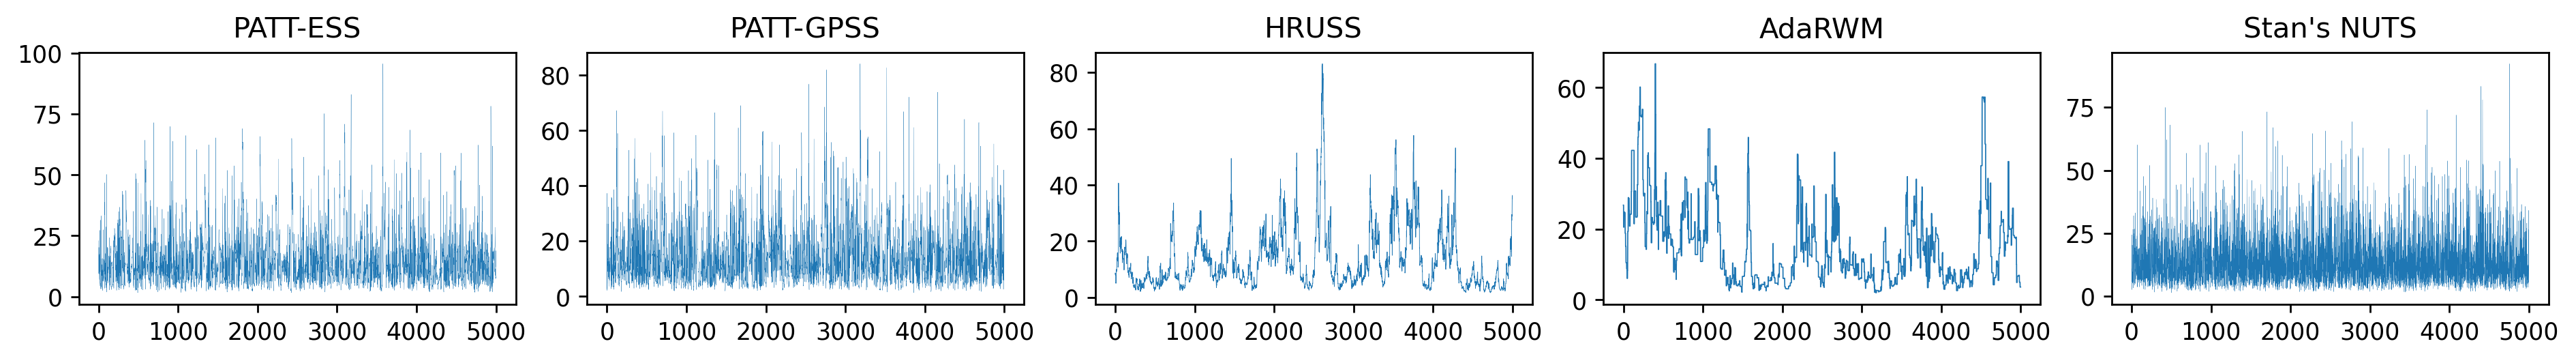

In [36]:
lws = [0.1, 0.1, 0.25, 0.5, 0.1]
path = path_prefix + "tfd_marginal_trace.png"
pfs.trace_plot_row([sams[-n_win:,0,0] for sams in tfd_samples], snames, dpi=dpi, filepath=path, lws=lws)

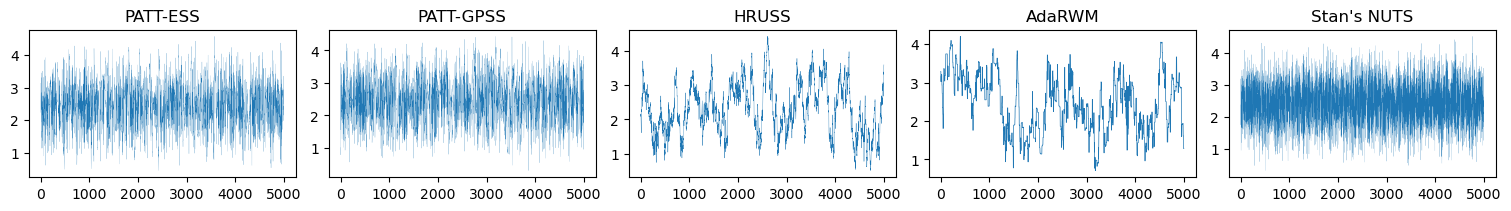

In [37]:
path = path_prefix + "marginal_trace.png"
pfs.trace_plot_row([sams[-n_win:,0,0] for sams in samples], snames, filepath=path, lws=lws)

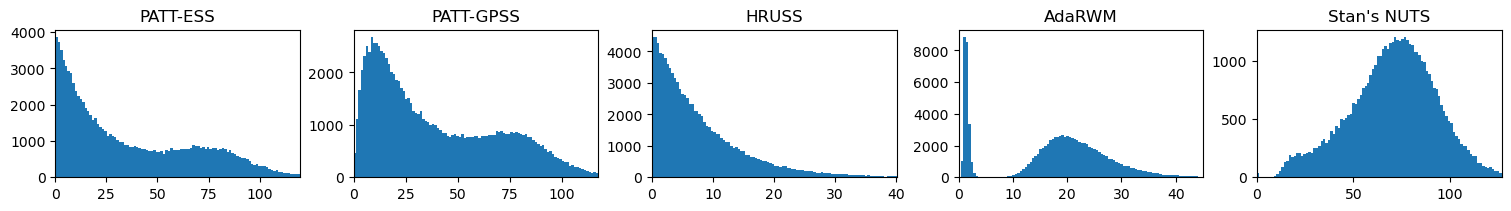

In [38]:
plot_steps = [np.copy(fs) for fs in flat_steps]
plot_steps[3] = plot_steps[3][plot_steps[3] != 0.0]
path = path_prefix + "steps.png"
pfs.plot_step_hist_row(plot_steps, snames, filepath=path)

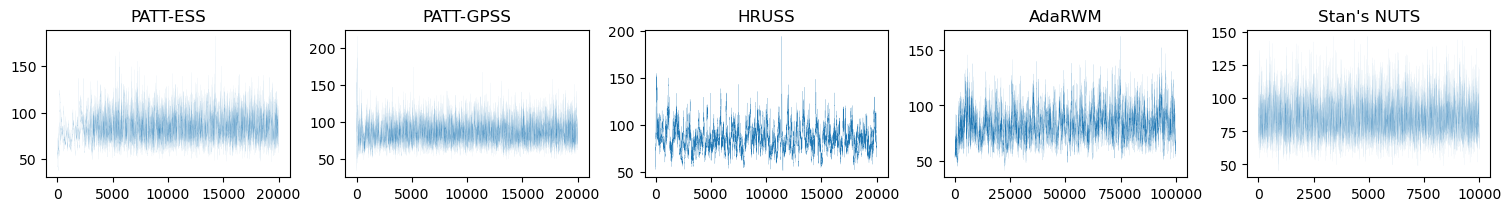

In [39]:
lws = [0.025, 0.025, 0.1, 0.05, 0.025]
pfs.trace_plot_row([frs[:,0] for frs in full_radii], snames, lws=lws)

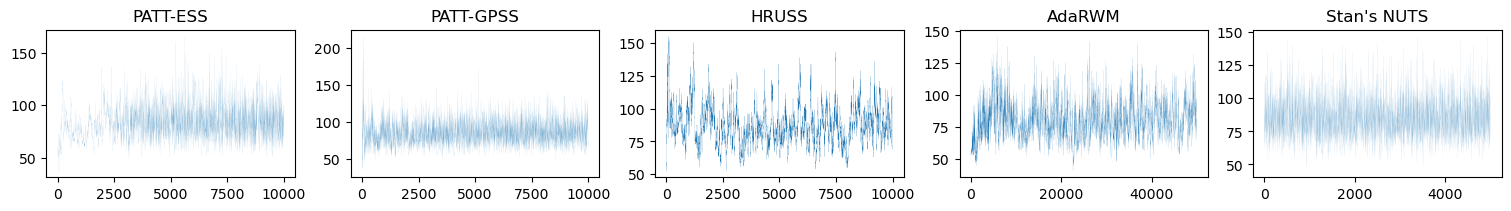

In [40]:
pfs.trace_plot_row([brs[:,0] for brs in burn_radii], snames, lws=lws)

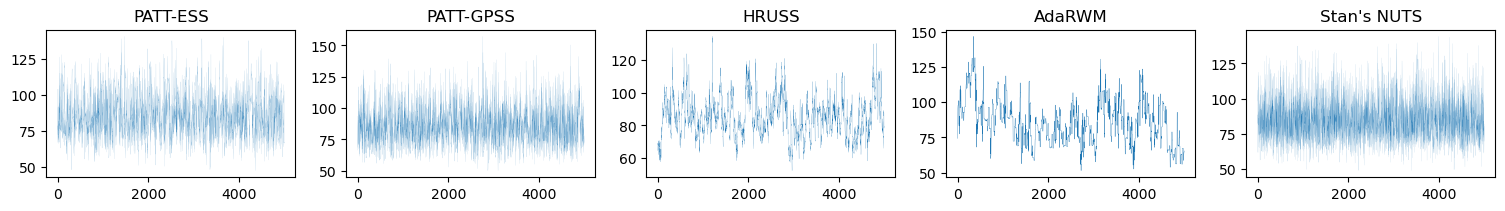

In [41]:
lws = [0.05, 0.05, 0.1, 0.25, 0.05]
pfs.trace_plot_row([rs[-n_win:,0] for rs in radii], snames, lws=lws)

**Note:** The above radius plot should give a particularly good glimpse into the frequency with which the different samplers ventured far into the tails, and correspondingly how much effort it took them to embark on and eventually return from these trips.

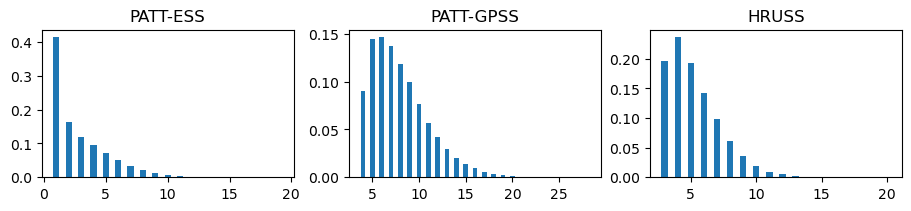

In [42]:
tde_inds = [0,1,2]
pfs.plot_tde_distr_row([tde[i] for i in tde_inds], [snames[i] for i in tde_inds])

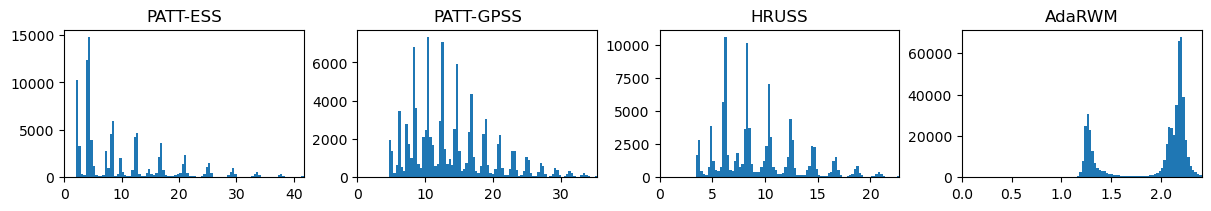

In [43]:
# plot histograms of per-iteration runtimes in milliseconds
granular_times = [0,1,2,3]
pfs.plot_runtime_hist_row([times[i]/1e3 for i in granular_times], 
                          [snames[i] for i in granular_times], nbins=100, cutoff_quant=0.99)

In [44]:
acc_rates_rwm = np.mean(ldv_rwm[n_its_rwm//2+1:] != ldv_rwm[n_its_rwm//2:-1], axis=0)
print("Average AdaRWM acceptance rate: {:.3f}".format(np.mean(acc_rates_rwm)))
print("Minimal AdaRWM acceptance rate: {:.3f}".format(np.min(acc_rates_rwm)))
print("Maximal AdaRWM acceptance rate: {:.3f}".format(np.max(acc_rates_rwm)))

Average AdaRWM acceptance rate: 0.213
Minimal AdaRWM acceptance rate: 0.180
Maximal AdaRWM acceptance rate: 0.248


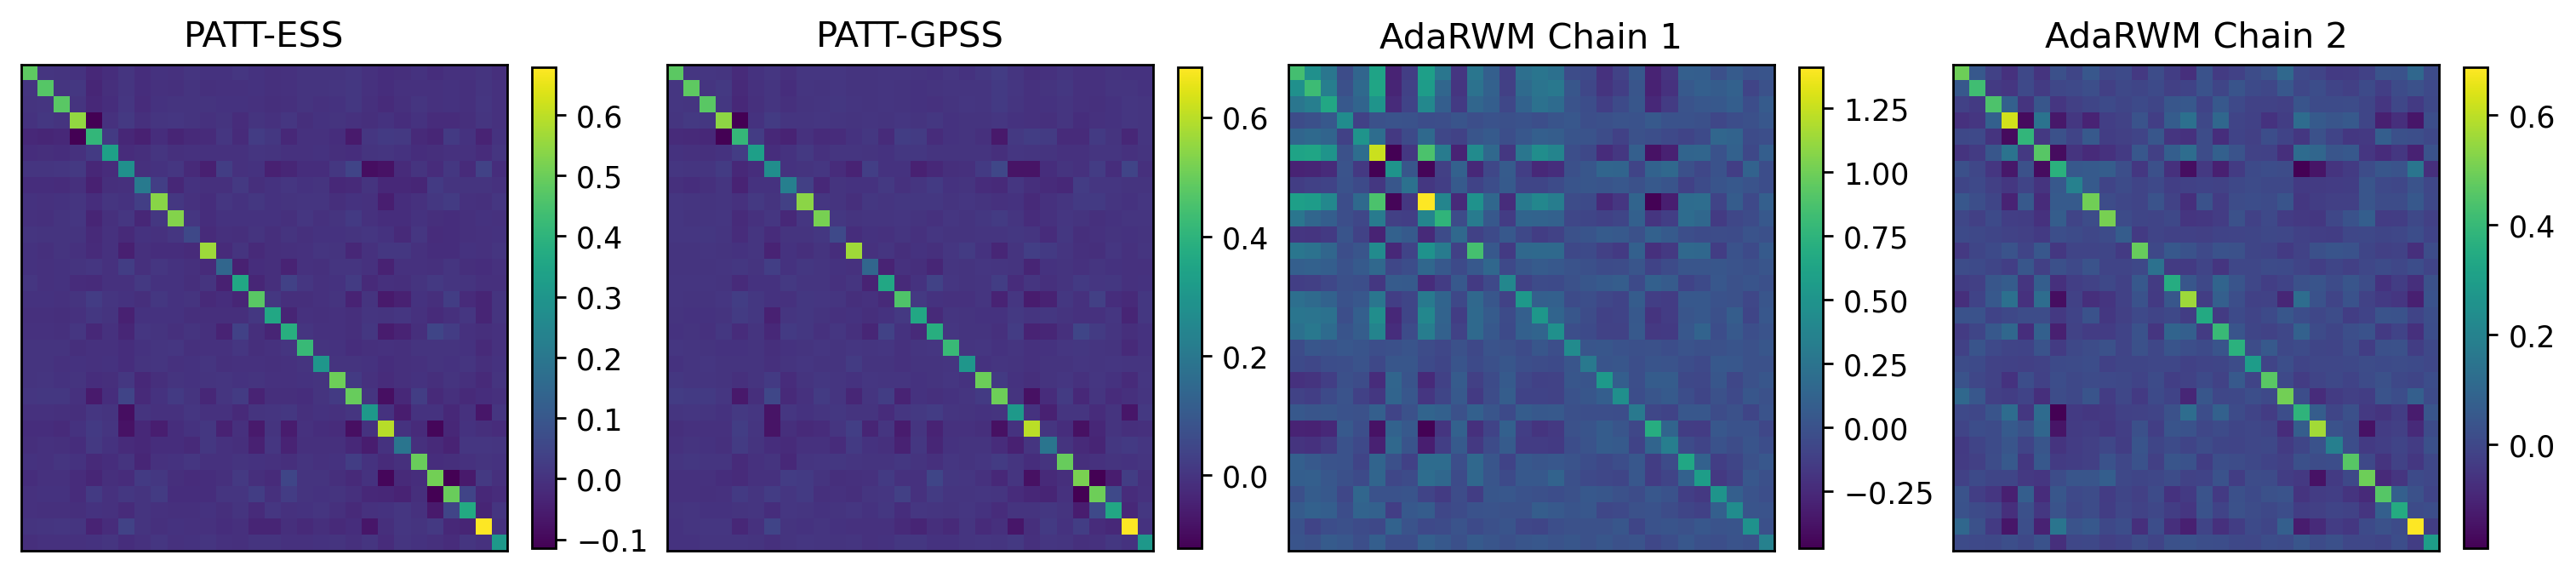

In [45]:
titles = ["PATT-ESS", "PATT-GPSS", "AdaRWM Chain 1", "AdaRWM Chain 2"]
covs = [covs_ess[-1], covs_gpss[-1], cov_rwm[0], cov_rwm[1]]
path = path_prefix + "covs.png"
pfs.plot_covs_row(covs, titles, filepath=path, shrink=0.775)

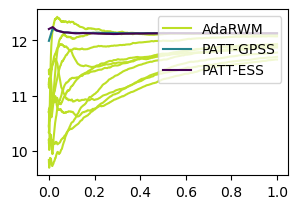

In [46]:
# plot progressions of the norm of each sampler's posterior mean approximation
norms_ess = mcu.get_radii(means_ess)
norms_gpss = mcu.get_radii(means_gpss)
norms_rwm = mcu.get_radii(means_rwm)
colors = plt.cm.viridis(np.linspace(0, 0.9, 3))
pfs.initiate((3,2),100)
plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,0], color=colors[2], label=snames[3])
for i in range(1,n_chains):
    plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,i], color=colors[2])
plt.plot(schedule_gpss / schedule_gpss[-1], norms_gpss, color=colors[1], label=snames[1])
plt.plot(schedule_ess / schedule_ess[-1], norms_ess, color=colors[0], label=snames[0])
plt.legend(loc='upper right')
pfs.wrapup()

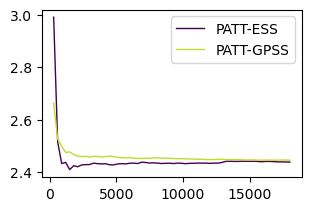

In [47]:
# plot progressions of the norm of the PATT samplers' posterior coordinate variance approximations
cov_norms_ess = mcu.get_radii(covs_ess.reshape(-1,d*d))
cov_norms_gpss = mcu.get_radii(covs_gpss.reshape(-1,d*d))
colors = plt.cm.viridis(np.linspace(0, 0.9, 2))
pfs.initiate((3,2),100)
plt.plot(schedule_ess[1:], cov_norms_ess[1:], color=colors[0], linewidth=1)
plt.plot(schedule_gpss[1:], cov_norms_gpss[1:], color=colors[1], linewidth=1)
plt.legend(snames[:2])
pfs.wrapup()

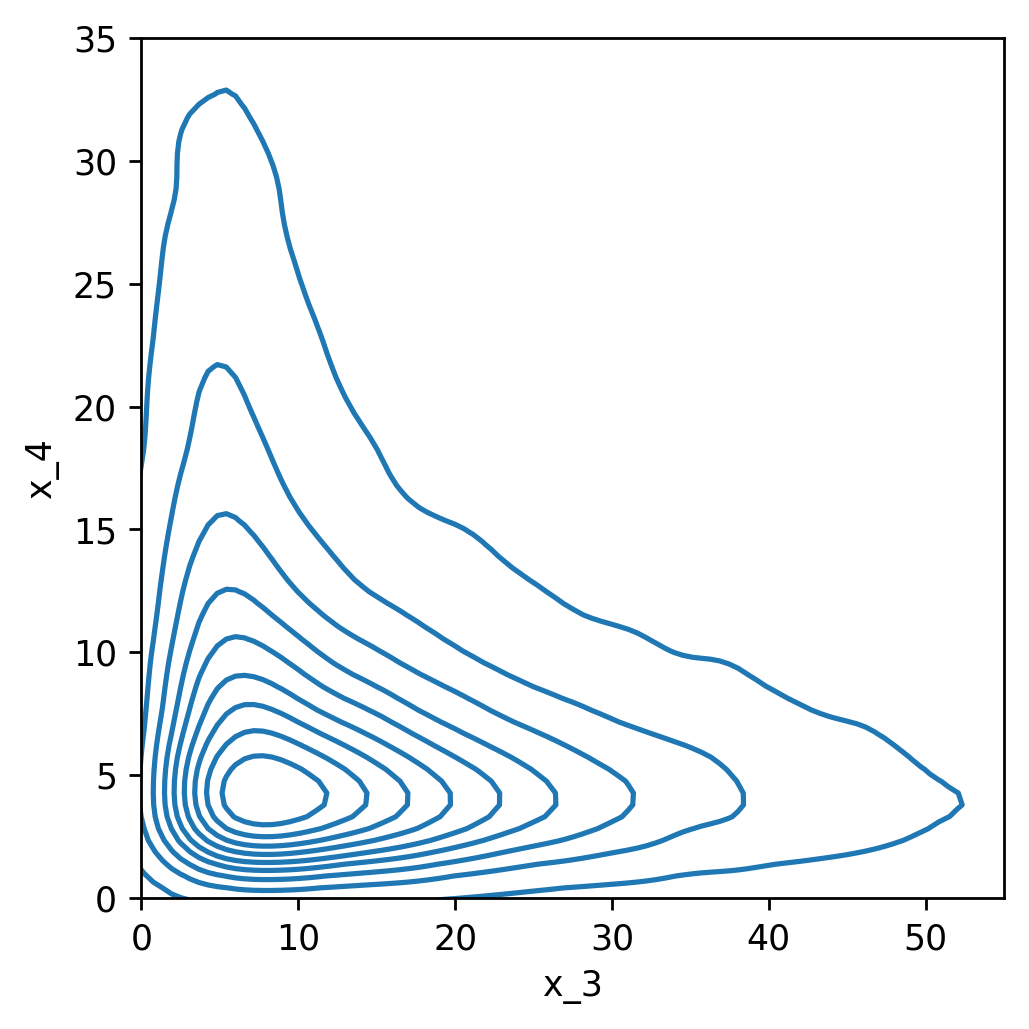

In [48]:
# generate illustration of untransformed target (based on the transformed samples) for the paper
inds = [3,4]
figsize = (4,4)
ax_labels = ["x_{}".format(inds[0]), "x_{}".format(inds[1])]
path = path_prefix + "bivariate_tfd_marginal.png"
biv_tfd_samples = np.concatenate([tfd_samples[-1].reshape(-1,d)[:,inds[0]].reshape(-1,1),
                                  tfd_samples[-1].reshape(-1,d)[:,inds[1]].reshape(-1,1)], axis=1)
frame = pd.DataFrame(biv_tfd_samples, columns=ax_labels)
pfs.initiate(figsize, dpi)
sb.kdeplot(frame, x=ax_labels[0], y=ax_labels[1])
# LIMITS MAY NEED TO BE ADAPTED TO CHOSEN DATA
plt.xlim(0,55) 
plt.ylim(0,35)
pfs.wrapup(path)

The above plot shows the untransformed version of the target to have level sets that are almost triangular and thus far from elliptical. For the transformed target, the level sets are much rounder though, as can be seen from the plot below.

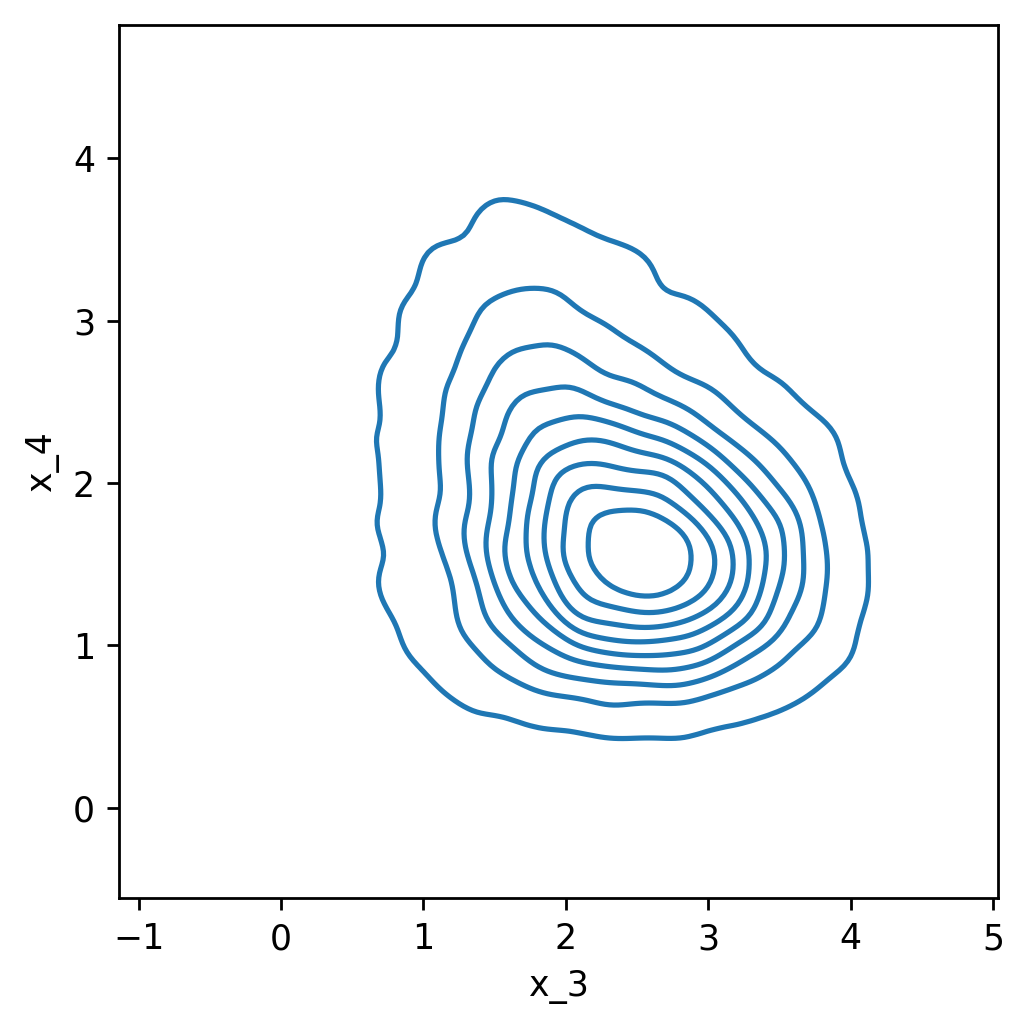

In [49]:
# generate illustration of transformed target (based on the untransformed samples) for the paper
path = path_prefix + "bivariate_marginal.png"
biv_samples = np.concatenate([samples[-1].reshape(-1,d)[:,inds[0]].reshape(-1,1),
                              samples[-1].reshape(-1,d)[:,inds[1]].reshape(-1,1)], axis=1)
frame = pd.DataFrame(biv_samples, columns=ax_labels)
pfs.initiate(figsize, dpi)
sb.kdeplot(frame, x=ax_labels[0], y=ax_labels[1])
pfs.wrapup(path)

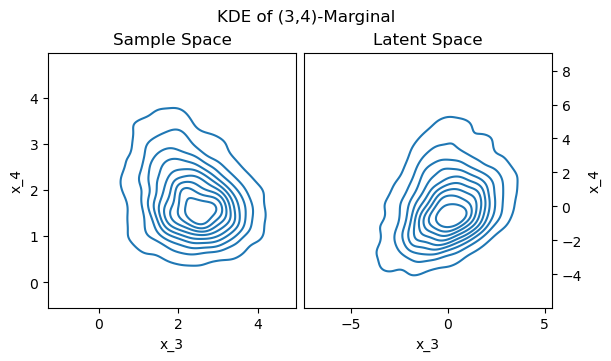

In [50]:
# plot a bivariate marginal KDE in sample space and (NUTS' final) latent space
fig, axes = plt.subplots(1,2, figsize=(6,3.5), dpi=100, constrained_layout=True)
fig.suptitle("KDE of ({},{})-Marginal".format(inds[0], inds[1]))
# left column: bivariate marginal in sample space
axes[0].set_title("Sample Space")
biv_sample_sp = np.concatenate([samples[-1][:,0,inds[0]].reshape(-1,1),
                                samples[-1][:,0,inds[1]].reshape(-1,1)], axis=1)
biv_sample_sp_frame = pd.DataFrame(biv_sample_sp, columns=ax_labels)
sb.kdeplot(biv_sample_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[0])
# right column: bivariate marginal in latent space
axes[1].set_title("Latent Space")
inv_cov = alg.inv(covs_gpss[-1])
alpha_inv = lambda y: inv_cov @ (y - means_gpss[-1])
plot_latent_samples = np.apply_along_axis(alpha_inv, -1, samples[-1][:,0])
biv_latent_sp = np.concatenate([plot_latent_samples[:,inds[0]].reshape(-1,1),
                                plot_latent_samples[:,inds[1]].reshape(-1,1)], axis=1)
biv_latent_sp_frame = pd.DataFrame(biv_latent_sp, columns=ax_labels)
sb.kdeplot(biv_latent_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[1])
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
pfs.wrapup()

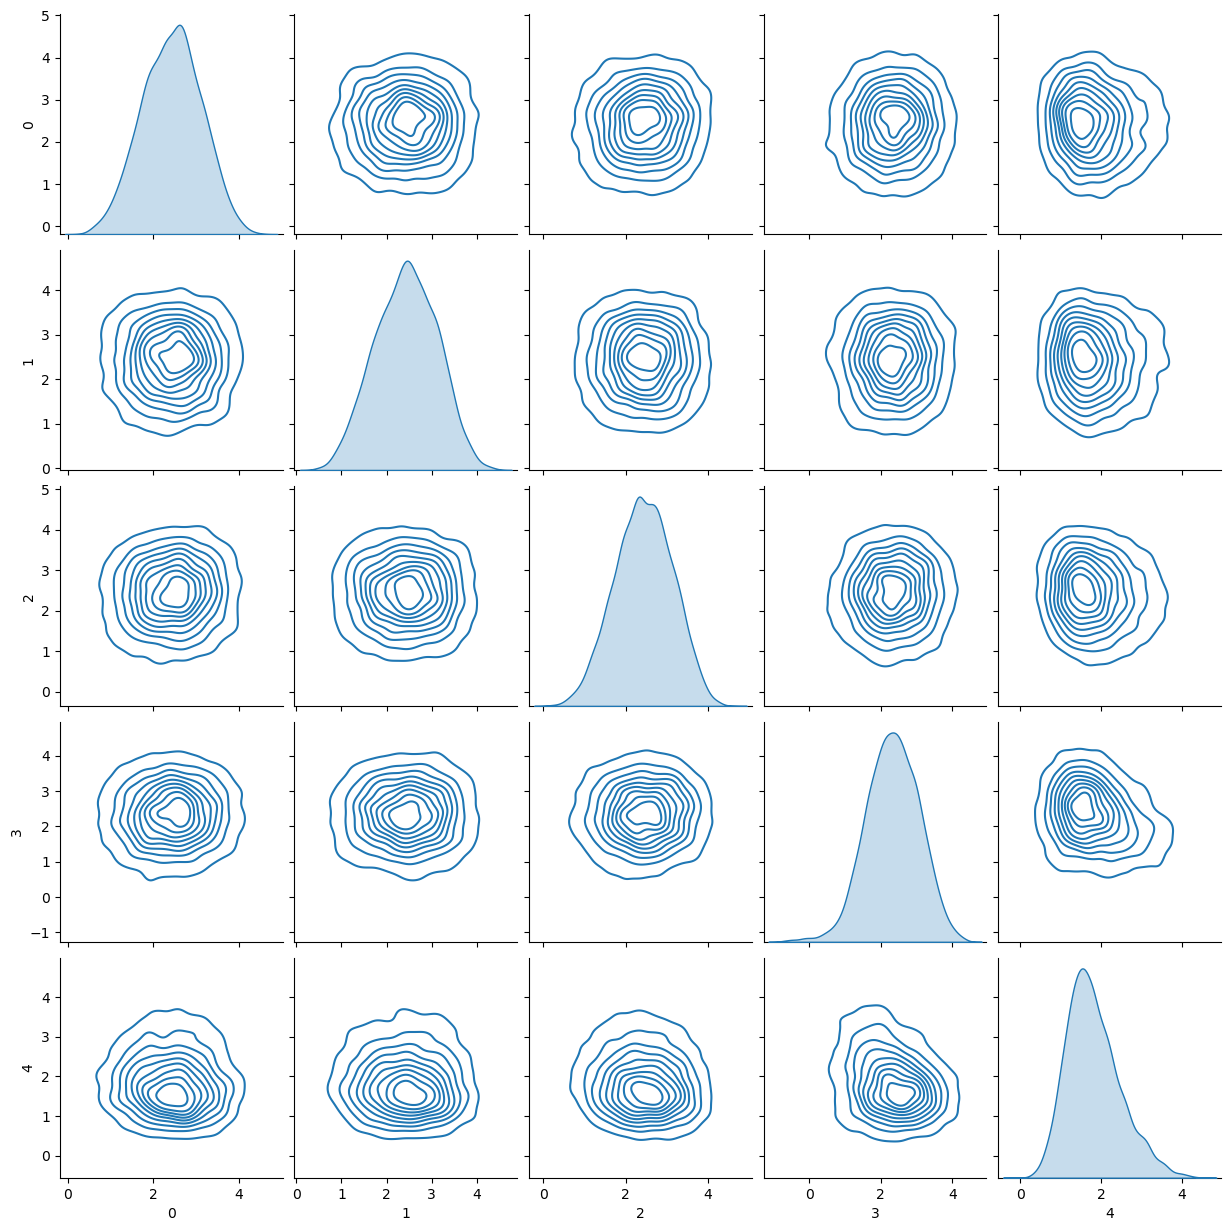

In [51]:
# this cell may take a few minutes to run
sb.pairplot(pd.DataFrame(samples[-1][-n_win:,0,:5]), kind='kde')
plt.show()